In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

/Users/fernandokenjisakabe/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading pipeline params.
DATA_PATH = Path('data')
FILENAME_STOP = 'stop_90_diff_quat.csv'
FILENAME_0 = '0_90_diff_quat.csv'
FILENAME_90 = '90_90_diff_quat.csv'
FILENAME_180 = '180_90_diff_quat.csv'
FILENAME_270 = '270_90_diff_quat.csv'

NUM_TIMESTEPS = 6
IGNORE_FRACTION = 0.1
TEST_FRACTION = 0.25

# Training params.
LEARNING_RATE = 1e-5
EPOCHS = 100
BATCH_SIZE = 512

In [3]:
def load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    num_timesteps,
    ignore_fraction,
    test_fraction,
):

    def read_and_prepare_data(
        path,
        class_,
        num_timesteps,
        ignore_fraction,
        test_fraction,
    ):

        def split_temporally(X, test_fraction):
            num_samples = X.shape[0]
            num_train = int(num_samples * (1.0 - test_fraction))
            X_train, X_test = X[:num_train], X[num_train:]
            return X_train, X_test

        def transform_into_sequences(X, num_timesteps):
            num_samples = X.shape[0]
            X_seq = []
            for k in range(num_samples - num_timesteps + 1):
                X_seq.append(X[k:(k + num_timesteps)])
            X_seq = np.array(X_seq)
            y_seq = class_ * np.ones((X_seq.shape[0], 1))
            return X_seq, y_seq

        X = pd.read_csv(path).values
        X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]  # Use only feet translations.

        # Ignore beginning and end.
        num_samples = X.shape[0]
        num_ignore = int(ignore_fraction * num_samples)
        X = X[num_ignore:-num_ignore]

        # Split X temporally.
        X_train, X_test = split_temporally(X, test_fraction)

        # Transform X into short sequences.
        X_train, y_train = transform_into_sequences(X_train, num_timesteps)
        X_test, y_test = transform_into_sequences(X_test, num_timesteps)

        return X_train, y_train, X_test, y_test

    def shuffle_data(X, y):
        idx = np.arange(len(X))
        default_rng().shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx]
        return X_shuffled, y_shuffled

    X_train_stop, y_train_stop, X_test_stop, y_test_stop = \
        read_and_prepare_data(
            path_stop,
            0.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_0, y_train_0, X_test_0, y_test_0 = \
        read_and_prepare_data(
            path_0,
            1.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train_90, y_train_90, X_test_90, y_test_90 = \
        read_and_prepare_data(
            path_90,
            2.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_180, y_train_180, X_test_180, y_test_180 = \
        read_and_prepare_data(
            path_180,
            3.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_270, y_train_270, X_test_270, y_test_270 = \
        read_and_prepare_data(
            path_270,
            4.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train = np.concatenate((X_train_stop, X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
    y_train = np.concatenate((y_train_stop, y_train_0, y_train_90, y_train_180, y_train_270), axis=0)
    X_test = np.concatenate((X_test_stop, X_test_0, X_test_90, X_test_180, X_test_270), axis=0)
    y_test = np.concatenate((y_test_stop, y_test_0, y_test_90, y_test_180, y_test_270), axis=0)

    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)

    return X_train, X_test, y_train, y_test


path_stop = Path(DATA_PATH, FILENAME_STOP)
path_0 = Path(DATA_PATH, FILENAME_0)
path_90 = Path(DATA_PATH, FILENAME_90)
path_180 = Path(DATA_PATH, FILENAME_180)
path_270 = Path(DATA_PATH, FILENAME_270)

X_train, X_test, y_train, y_test = load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    NUM_TIMESTEPS,
    IGNORE_FRACTION,
    TEST_FRACTION,
)

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100773, 6, 14), (100773, 1), (33575, 6, 14), (33575, 1))

In [5]:
X_test[60].shape


(6, 14)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

CNN = Sequential(name="Sequential_CNN")

CNN.add(Conv2D(256, kernel_size=(2, 2),
               strides=(4, 4), padding="same",
               activation="selu", input_shape=[6, 14, 1]))

CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
                     padding="valid"))

# Add another pair of Conv2D and MaxPooling2D for more model depth,
# followed by the flatten and multiple dense layers

# CNN.add(Conv2D(64, kernel_size=(3, 3),
#                strides=(1, 1), padding="same",
#                activation="selu"))

# CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
#                      padding="valid"))

CNN.add(Flatten())

CNN.add(Dense(64, activation='selu'))
CNN.add(Dense(32, activation='selu'))
CNN.add(Dense(5, activation='softmax'))

CNN.summary()

2023-01-18 17:57:34.400635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 4, 256)         1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 3, 256)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                    

In [7]:
from numpy import *
where_are_NaNsx = isnan(X_train)
X_train[where_are_NaNsx] = 0

where_are_NaNsy = isnan(y_train)
y_train[where_are_NaNsy] = 0

where_are_NaNsxt = isnan(X_test)
X_test[where_are_NaNsxt] = 0

where_are_NaNsyt = isnan(y_test)
y_test[where_are_NaNsyt] = 0

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = CNN.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=256,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/100
394/394 [==============================] - 9s 17ms/step - loss: 0.4874 - accuracy: 0.7944 - val_loss: 0.3203 - val_accuracy: 0.8345
Epoch 2/100
394/394 [==============================] - 7s 18ms/step - loss: 0.2390 - accuracy: 0.9176 - val_loss: 0.1652 - val_accuracy: 0.9427
Epoch 3/100
394/394 [==============================] - 7s 17ms/step - loss: 0.1715 - accuracy: 0.9443 - val_loss: 0.1499 - val_accuracy: 0.9506
Epoch 4/100
394/394 [==============================] - 7s 17ms/step - loss: 0.1416 - accuracy: 0.9550 - val_loss: 0.1708 - val_accuracy: 0.9274
Epoch 5/100
394/394 [==============================] - 5s 14ms/step - loss: 0.1337 - accuracy: 0.9563 - val_loss: 0.1394 - val_accuracy: 0.9563
Epoch 6/100
394/394 [==============================] - 6s 15ms/step - loss: 0.1190 - accuracy: 0.9614 - val_loss: 0.0874 - val_accuracy: 0.9803
Epoch 7/100
394/394 [==============================] - 5s 13ms/step - loss: 0.1268 - accuracy: 0.9583 - val_loss: 0.0935 - val_accuracy:

394/394 [==============================] - 6s 16ms/step - loss: 0.0485 - accuracy: 0.9852 - val_loss: 0.0628 - val_accuracy: 0.9859
Epoch 58/100
394/394 [==============================] - 6s 14ms/step - loss: 0.0518 - accuracy: 0.9837 - val_loss: 0.0524 - val_accuracy: 0.9878
Epoch 59/100
394/394 [==============================] - 6s 15ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.0789 - val_accuracy: 0.9702
Epoch 60/100
394/394 [==============================] - 6s 15ms/step - loss: 0.0502 - accuracy: 0.9846 - val_loss: 0.0840 - val_accuracy: 0.9789
Epoch 61/100
394/394 [==============================] - 6s 15ms/step - loss: 0.0536 - accuracy: 0.9831 - val_loss: 0.1099 - val_accuracy: 0.9429
Epoch 62/100
394/394 [==============================] - 6s 15ms/step - loss: 0.0473 - accuracy: 0.9853 - val_loss: 0.0488 - val_accuracy: 0.9895
Epoch 63/100
394/394 [==============================] - 6s 15ms/step - loss: 0.0502 - accuracy: 0.9845 - val_loss: 0.0625 - val_accuracy: 0.986

In [ ]:
# from functools import partial



# _, num_time, num_feat = X_train.shape

# activation = 'selu'

# DefaultConv1D = partial(
#     keras.layers.Conv1D,
#     kernel_size=1,
#     activation=activation,
#     padding="valid",
# )

# model = keras.models.Sequential([
#     DefaultConv1D(4 * num_feat, kernel_size=2, input_shape=[num_time, num_feat]),
#     keras.layers.BatchNormalization(),
#     DefaultConv1D(num_feat, kernel_size=2),
#     keras.layers.Flatten(),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_time * num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(5, activation='softmax'),
# ])

# optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=optimizer,
#     metrics=['accuracy'],
# )

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_test, y_test),
#     verbose=1,
# )

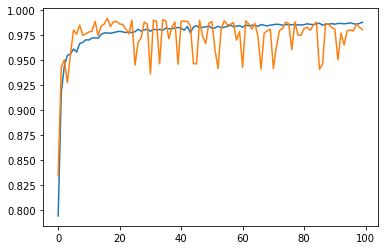

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

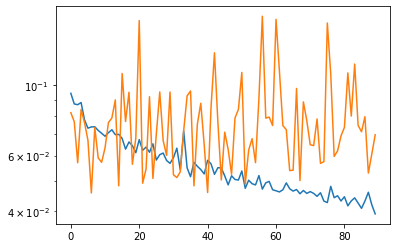

In [10]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.yscale('log')

In [11]:
y_pred = CNN.predict(X_test)

1050/1050 [==============================] - 5s 4ms/step


In [12]:
y_pred

array([[2.8351855e-03, 2.1488948e-09, 9.9716479e-01, 6.1932031e-12,
        1.4371302e-35],
       [9.9999487e-01, 2.0017689e-19, 3.7515969e-20, 5.0694357e-06,
        6.4383340e-21],
       [5.7735684e-11, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00],
       ...,
       [1.2104651e-02, 1.1005428e-09, 2.7163747e-11, 9.8789537e-01,
        1.7989901e-14],
       [2.0935573e-08, 1.2117967e-23, 7.5133711e-25, 4.2304089e-23,
        1.0000000e+00],
       [9.9996853e-01, 6.4110765e-08, 3.1353164e-05, 1.3064556e-15,
        0.0000000e+00]], dtype=float32)

In [13]:
y_pred= np.argmax(y_pred, axis=1)

In [14]:
y_pred

array([2, 0, 4, ..., 3, 4, 0])

In [15]:
y_pred[0]

2

In [16]:
df = pd.DataFrame({
    'y_test': y_test.ravel().astype(int).tolist(),
    'y_pred': y_pred.ravel().astype(int).tolist(),
})

In [17]:
pd.crosstab(df['y_test'], df['y_pred'])

y_pred,0,1,2,3,4
y_test,,,,,
0,13916,1,145,333,0
1,52,4722,0,21,0
2,52,0,4743,0,0
3,46,0,0,4749,0
4,3,0,0,0,4792


In [ ]:
model.save('model.h5')

In [18]:
CNN.save('model_90_98_rotate_math.h5')